In [ ]:
'''
Use the notebook to test one example for testing

'''

In [1]:

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
import trimesh
import os
from loguru import logger
from pathlib import Path
import numpy as np
from trimesh.transformations import scale_matrix, translation_matrix
from pytorch3d.io import load_obj, save_obj, load_ply,load_objs_as_meshes
from pytorch3d.io import IO
import pytorch3d

from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    FoVOrthographicCameras,
    Materials,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    PointLights,
    SoftPhongShader,
    TexturesVertex,
    HardPhongShader,
    Textures,
    TexturesUV,
    TexturesAtlas,
    PointsRenderer,
    PointsRasterizationSettings,
    PointsRasterizer
)


from pytorch3d.structures import Meshes

import sys
sys.path.append("../")
from rendererClass import RendererClass

import matplotlib.pyplot as plt
import json
import itertools
import torch

In [11]:
save_path = "/home/andstasi/Projects/MediaVerse/3D_to_2D_converter/pytorch3d-renderer/data/random_example/Kitchen/GLB_format/scene/GLB_to_OBJ_force_scene.obj"
#save_path = "/home/andstasi/Projects/MediaVerse/3D_to_2D_converter/pytorch3d-renderer/data/random_example/Liberty/scene/GLB_to_OBJ_force_scene.obj"
save_path = "/home/andstasi/Projects/MediaVerse/3D_to_2D_converter/pytorch3d-renderer/data/random_example/girl/scene/GLB_to_OBJ_force_scene.obj"
save_path = "/home/andstasi/Projects/MediaVerse/3D_to_2D_converter/pytorch3d-renderer/data/random_example/S3DIS_examples/PLY_to_OBJ.obj"
save_path = "/home/andstasi/Projects/MediaVerse/3D_to_2D_converter/pytorch3d-renderer/data/random_example/Several_format/bed_room/untitled.obj"
save_path = "/home/andstasi/Projects/MediaVerse/3D_to_2D_converter/pytorch3d-renderer/data/random_example/Astronaut/scene/GLB_to_OBJ_force_scene.obj"

verts, faces, aux = load_obj(
        save_path,
        device=device,
        load_textures=True)

In [3]:
io = IO()
save_path = "/home/andstasi/Projects/MediaVerse/3D_to_2D_converter/pytorch3d-renderer/data/random_example/Several_format/full_body_scan/Full body PLY/full_body.ply"
#save_path = "/home/andstasi/Projects/MediaVerse/3D_to_2D_converter/pytorch3d-renderer/data/random_example/Several_format/full_body_scan/Full body OBJ/full_body.obj"
save_path  = "/home/andstasi/Projects/MediaVerse/3D_to_2D_converter/pytorch3d-renderer/data/random_example/Several_format/tiger/Golden Tiger.ply"
save_path = "/home/andstasi/Projects/MediaVerse/3D_to_2D_converter/pytorch3d-renderer/data/random_example/Liberty/scene/GLB_to_OBJ_force_scene.obj"


mesh = io.load_mesh(save_path, include_textures= True,device = device)

/home/andstasi/anaconda3/envs/triton_inf/lib/python3.8/site-packages/pytorch3d/io/utils.py:66: UserWarning: Faces have invalid indices
  warnings.warn("Faces have invalid indices")


In [4]:
param_path = "/home/andstasi/Projects/MediaVerse/3D_to_2D_converter/pytorch3d-renderer/params_inference.json"
with open(param_path) as f:
    params = json.load(f)

device = "cuda:1"
#load the pars to render 3D
all_dist = params["camera_dist"]
all_elev = params["elevation"]
all_azim = params["azim_angle"]

#get all combinations
all_combs =  list(itertools.product(*[all_dist,all_elev,all_azim]))

In [33]:
verts, faces, aux = load_obj(
        save_path,
        device=device,
        load_textures = True)
        
        
        


In [ ]:
verts, faces, aux = load_obj(
        save_path,
        device=device,
        load_textures=True,
        create_texture_atlas=True,
        texture_atlas_size=4,
        texture_wrap="repeat"
        )

In [5]:
tex_maps = aux.texture_images
if tex_maps is not None and len(tex_maps) > 0:
    print("dsds")
    verts_uvs = aux.verts_uvs.to(device)
    faces_uvs = faces.textures_idx.to(device)
    image = list(tex_maps.values())[0].to(device)[None]
    #image = list(tex_maps.values())
    tex = TexturesUV(verts_uvs=[verts_uvs], faces_uvs=[faces_uvs], maps=image)

dsds


In [6]:
renderer = RendererClass(params)
verts = verts.to(device)
faces_idx = faces.verts_idx.to(device) #get ids from the faces for back projecting

# normalize and center the mesh
verts = renderer.pre_process(verts)
   


normalize the input in a unit shpere


In [7]:
# Create Meshes object
mesh = Meshes(
    verts=[verts],
    faces=[faces_idx],
    textures=tex)

In [45]:

'''# Create Meshes object
mesh = Meshes(
    verts=[verts],
    faces=[faces_idx])    '''
   
    
# ------ Create a textured object -----------
atlas = aux.texture_atlas



mesh = Meshes(
    verts=[verts],
    faces=[faces_idx],
    textures=TexturesAtlas(atlas=[atlas]),)


In [10]:
#color = torch.ones(1, verts.size(0), 3, device=device)
color = torch.ones(1, mesh.verts_list()[0].shape[0], 3, device=device)
#features = torch.from_numpy(np.array(aux.texture_images.values(),dtype='float32'))[None]
mesh.textures = TexturesVertex(verts_features=color)

In [8]:
dist,elev,azim = all_combs[0]
image_size = 1024

R, T = look_at_view_transform(dist=2, elev=elev, azim=azim)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)
raster_settings = RasterizationSettings(
    image_size=image_size,
    blur_radius=0.0,
    clip_barycentric_coords=True,
    faces_per_pixel=1,
)
# Initialize rasterizer by using a MeshRasterizer class
rasterizer = MeshRasterizer(
    cameras=cameras,
    raster_settings=raster_settings
)
# The textured phong shader interpolates the texture uv coordinates for
# each vertex, and samples from a texture image.
shader = HardPhongShader(device=device, cameras=cameras,lights = PointLights(device=device))

# Create a mesh renderer by composing a rasterizer and a shader
renderer = MeshRenderer(rasterizer, shader)

In [75]:
'''mesh = load_objs_as_meshes(
        [save_path],
        device=device,
        load_textures=True,
        create_texture_atlas=True,
        texture_atlas_size=4,
        texture_wrap="repeat"
        )

verts = verts.to(device)
faces_idx = faces.verts_idx.to(device) #get ids from the faces for back projecting

# normalize and center the mesh
verts = renderer.pre_process(verts)'''

AttributeError: 'MeshRenderer' object has no attribute 'pre_process'

In [9]:

image = renderer(mesh)[0, ..., :3].cpu().numpy()

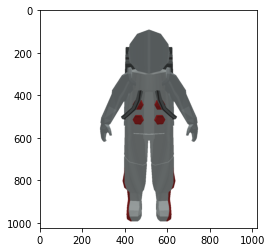

In [10]:
plt.imshow(image)
plt.show()

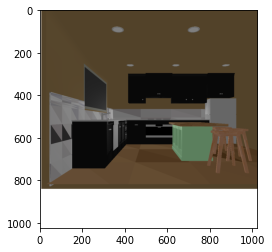

In [52]:
plt.imshow(image)
plt.show()